In [38]:
import torch
import sys
import pyro

import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal, AutoGuideList, AutoDelta
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data, pyro_utils

from importlib import reload

from pathlib import Path

def guide(data, device = "cpu", asb_flag = True):
    
    num_snps = len(data[0])
    
    z1 = pyro.sample(
        "z1", 
        dist.Normal(
            torch.zeros(num_snps, device = device), 
            torch.ones(num_snps, device = device)).to_event(1),
        infer={'is_auxiliary': True})
    
    ase_loc = pyro.param('ase_loc', lambda: torch.zeros(num_snps, device = device))
    
    ase_scale_param = pyro.param(
        'ase_scale_param', 
        lambda: torch.ones(num_snps, device = device), 
        constraint=constraints.positive)

    ase = pyro.sample(
        "ase",  
        dist.Delta(
            ase_loc + ase_scale_param * z1,
            log_density = -ase_scale_param.log()).to_event(1)) # does work if we switch sign, or set = 0
    
    if asb_flag: 
        z2 = pyro.sample(
            "z2", 
            dist.Normal(
                torch.zeros(num_snps, device = device),
                torch.ones(num_snps, device = device)).to_event(1),
            infer={'is_auxiliary': True})
        
        asb_loc = pyro.param('asb_loc', lambda: torch.zeros(num_snps, device = device))
        asb_scale_param = pyro.param(
            'asb_scale_param', 
            lambda: torch.ones(num_snps, device = device), 
            constraint=constraints.positive)
    
        asb_corr = pyro.param(
            'asb_corr', 
            lambda: torch.zeros(num_snps, device = device))

        asb = pyro.sample('asb', dist.Delta(
            asb_loc + asb_corr * z1 + asb_scale_param * z2,
            log_density = -asb_scale_param.log()).to_event(1))


In [39]:
def model(data):
    ase = pyro.sample("ase", 
        dist.Normal(data[0], data[1]).to_event(1)
    )
    asb = pyro.sample("asb", 
        dist.Normal(data[2], data[3]).to_event(1)
    )

In [41]:
num_snps = 100
means = torch.randn(num_snps)
scales = torch.rand(num_snps)

means_asb = torch.randn(num_snps)
scales_asb = torch.rand(num_snps)

data = [means, scales, means_asb, scales_asb]

model(data)

In [42]:
def fit(model, guide, data, lr = 0.03, iterations = 200):
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO() ) 
    pyro.clear_param_store()
    losses = []
    for j in range(iterations):
        loss = svi.step(data)
        losses.append(loss)
        print("[iteration %04d] loss: %.4f" % (j + 1, loss), end = "\r")
    return losses


losses = fit(model,guide,data,iterations=1000)

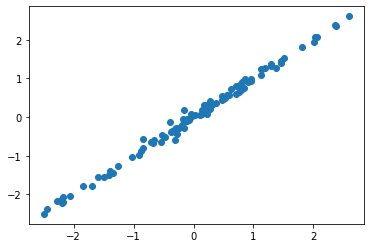

In [43]:
plt.scatter(means, pyro.param('ase_loc').detach())

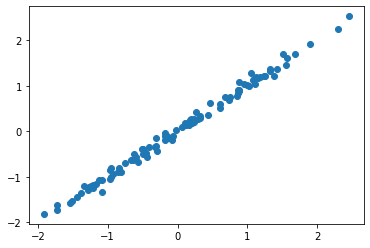

In [45]:
plt.scatter(means_asb, pyro.param('asb_loc').detach())

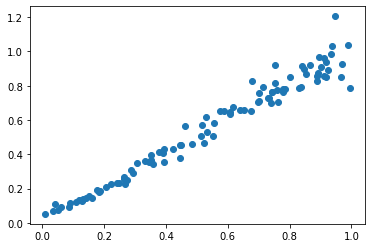

In [44]:
plt.scatter(scales, pyro.param('ase_scale_param').detach())


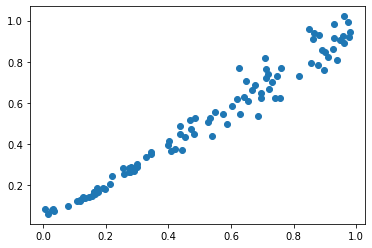

In [46]:
plt.scatter(scales_asb, pyro.param('asb_scale_param').detach())

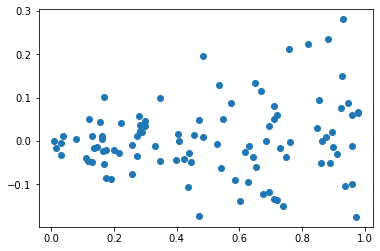

In [47]:
plt.scatter(scales_asb, pyro.param('asb_corr').detach())